# Training a regression with two outputs

Going to train a regression here, with two outputs to make sure we have the structure correct

## Settings

In [1]:
n_variables = 4 # Number of data and background varialbes to generate
n_samples = 10000 # Number of samples to generate

center_signal = 2.0 # Where the gaussian for signal should be
center_background = 1.0 # Where the gaussian for background should be

In [2]:
import sys
sys.path += ['../abcdlib']
import data_gen

import seaborn as sns
import pandas as pd
from torch import nn
from torch import optim
import torch
import numpy as np

## Generate the data

In [3]:
sig = data_gen.generate_gaussian(n_variables, center_signal, n_samples)
back = data_gen.generate_gaussian(n_variables, center_background, n_samples)

half = int(n_samples/2)

training = data_gen.combine(sig[:half], back[:half])
testing = data_gen.combine(sig[half:], back[half:])

## Train with one output

For a regression, we need just a single output column with the 1 or 0 as the target value. Of course, this time we need 2 columns, duplicated.

In [4]:
label = training[training.columns[-1]].values
labels = np.stack((label, label), axis=1)

In [5]:
x_train = torch.Tensor(training[training.columns[:-1]].values)
y_train = torch.Tensor(labels)

Next create a simple classifier - 2 layers, with the same number of nodes as inputs. It looks like doubling the size of the inputs and outputs makes a big difference, but in general getting this to train better hasn't been successful so far. No idea why.

In [6]:
model = nn.Sequential(nn.Linear(n_variables, n_variables*2),
                      nn.ReLU(),
                      nn.Linear(n_variables*2, n_variables),
                      nn.ReLU(),
                      nn.Linear(n_variables, 2))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

Now lets do the training

In [7]:
epochs = 5000
for e in range(epochs):
    running_loss = 0
    optimizer.zero_grad()
    output = model(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
else:
    print(f'Training loss: {running_loss/len(x_train)}')

Training loss: 1.1082058399915695e-05


## Prediction

Get the predicted probabilities out and see where they line up and how well this guy did!

In [8]:
x_test = torch.Tensor(testing[testing.columns[:-1]].values)
y_test = model(x_test)

In [9]:
x_results = testing.copy()
x_results['Prediction_1'] = y_test.detach().numpy()[:,0]
x_results['Prediction_2'] = y_test.detach().numpy()[:,1]

<AxesSubplot:xlabel='Prediction_1', ylabel='Count'>

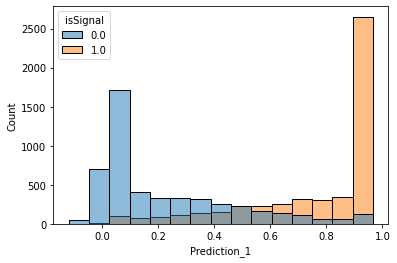

In [10]:
sns.histplot(x_results, x='Prediction_1', hue='isSignal')

<AxesSubplot:xlabel='Prediction_2', ylabel='Count'>

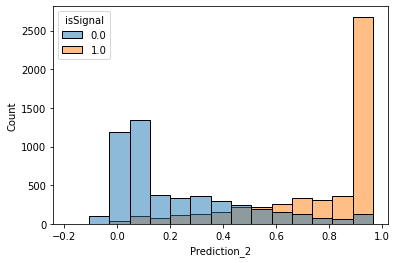

In [11]:
sns.histplot(x_results, x='Prediction_2', hue='isSignal')

Lets look at the correlation between these on background and signal data

<AxesSubplot:xlabel='Prediction_1', ylabel='Prediction_2'>

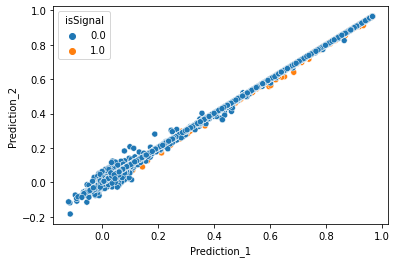

In [12]:
sns.scatterplot(data=x_results, x='Prediction_1', y='Prediction_2', hue='isSignal')

Other than something odd going on down near zero, this looks very correlated for background (and signal). We need the background to be uncorrelated...

## Exploring the correlation

In order to determine the loss function we'll need to ask for these two to be uncorrelated. Which means the correlation on the background is going to be part of the calculation. How do we calculate correlation in PyTorch?

In [13]:
def calc_r(prediction):
    mean = torch.mean(prediction, dim=0)
    std_dev = torch.std(prediction, dim=0)
    parts = (prediction - mean)
    sum = torch.sum(parts[:,0]*parts[:,1])
    return sum / std_dev[0] / std_dev[1] / (prediction.shape[0]-1)

In [14]:
calc_r(y_test)

tensor(0.9998, grad_fn=<DivBackward0>)

A possible loss function is $(r+1)/2.0$, as that would keep it between 0 and 1. Though next I need to learn about writing our own loss function for this... basically, we probably want this to be as small as possible when it is _good_. So that might just mean $r^2$.